In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)

## Loading

In [2]:
raw_train_data = pd.read_csv('../input/train.csv')
raw_train_data.shape

(42000, 785)

In [3]:
images = raw_train_data.values[:, 1:]
labels = raw_train_data.values[:, 0]

## Preprocessing

### Normalization

In [4]:
images = images / 255

### Reshaping

In [5]:
images = images.reshape(-1, 28, 28, 1)

### One Hot Encoding

In [6]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=10)

Using TensorFlow backend.


### Splitting

In [7]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1)

## Training

### Instantiating

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D

`((Conv2D -> ReLU) * 2 -> MaxPool2D -> Dropout) * 2 -> Flatten -> Dense -> Dropout -> Out`

In [9]:
model = Sequential()

model.add(Conv2D(
  filters=32,
  kernel_size=(5, 5),
  padding='Same',
  activation='relu',
  input_shape=(28, 28, 1),
))
model.add(Conv2D(
  filters=32,
  kernel_size=(5, 5),
  padding='Same',
  activation='relu',
))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(
  filters=64,
  kernel_size=(3, 3),
  padding='Same',
  activation='relu'
))
model.add(Conv2D(
  filters=64,
  kernel_size=(3, 3),
  padding='Same',
  activation='relu',
))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
model.input_shape

(None, 28, 28, 1)

In [11]:
model.output_shape

(None, 10)

### Compiling

In [12]:
from keras.optimizers import RMSprop

In [13]:
optimizer = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-8, decay=0.0)

In [14]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fitting

In [15]:
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [16]:
epochs = 30
batch_size = 86

In [17]:
lr_annealer = ReduceLROnPlateau(
  monitor='val_acc',
  patience=3,
  factor=0.5,
  min_lr=1e-5,
  verbose=1,
)

In [18]:
datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=False,
  samplewise_std_normalization=False,
  zca_whitening=False,
  rotation_range=10,
  zoom_range=0.1,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=False,
  vertical_flip=False,
)
datagen.fit(train_images)
batches = datagen.flow(train_images, train_labels, batch_size=batch_size)

In [19]:
history = model.fit_generator(
  batches,
  steps_per_epoch=train_images.shape[0] // batch_size,
  validation_data=(val_images, val_labels),
  callbacks=[lr_annealer],
  epochs=epochs,
  verbose=2,
)

Epoch 1/30
 - 442s - loss: 0.4427 - acc: 0.8563 - val_loss: 0.0592 - val_acc: 0.9814
Epoch 2/30
 - 375s - loss: 0.1455 - acc: 0.9576 - val_loss: 0.0508 - val_acc: 0.9845
Epoch 3/30
 - 388s - loss: 0.1059 - acc: 0.9684 - val_loss: 0.0319 - val_acc: 0.9893
Epoch 4/30
 - 386s - loss: 0.0923 - acc: 0.9735 - val_loss: 0.0369 - val_acc: 0.9871
Epoch 5/30
 - 380s - loss: 0.0802 - acc: 0.9762 - val_loss: 0.0335 - val_acc: 0.9898
Epoch 6/30
 - 378s - loss: 0.0797 - acc: 0.9771 - val_loss: 0.0281 - val_acc: 0.9914
Epoch 7/30
 - 339s - loss: 0.0798 - acc: 0.9775 - val_loss: 0.0275 - val_acc: 0.9926
Epoch 8/30
 - 362s - loss: 0.0748 - acc: 0.9786 - val_loss: 0.0345 - val_acc: 0.9914
Epoch 9/30
 - 371s - loss: 0.0771 - acc: 0.9796 - val_loss: 0.0262 - val_acc: 0.9914
Epoch 10/30
 - 366s - loss: 0.0750 - acc: 0.9797 - val_loss: 0.0346 - val_acc: 0.9907
Epoch 11/30
 - 367s - loss: 0.0736 - acc: 0.9797 - val_loss: 0.0238 - val_acc: 0.9933
Epoch 12/30
 - 338s - loss: 0.0765 - acc: 0.9792 - val_loss: 0.

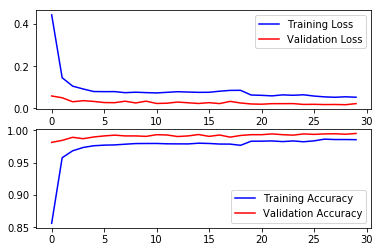

In [20]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend(loc='best')
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
ax[1].legend(loc='best');

## Predicting

In [21]:
test_images = pd.read_csv('../input/test.csv')
test_images = test_images.values.reshape(-1, 28, 28, 1)
test_images = test_images / 255

In [22]:
predictions = model.predict_classes(test_images)

## Saving

In [23]:
df = pd.DataFrame(predictions)
df.index += 1
df.index.name = 'ImageId'
df.columns = ['Label']
df.to_csv('results.csv')